# Important Traffic Nodes

### Initialize

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType

spark = SparkSession \
    .builder \
    .appName("Spark_Processor") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",IntegerType(),True), \
        StructField("FINAL_CAR_KEY", IntegerType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

22/02/11 19:51:54 WARN Utils: Your hostname, amin-X556UQK resolves to a loopback address: 127.0.1.1; using 192.168.43.227 instead (on interface wlp3s0)
22/02/11 19:51:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/11 19:51:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Traffic.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



##### Keep only 7 days

In [3]:
from pyspark.sql.functions import dayofyear
df = df.withColumn('day', dayofyear(df.PASS_DAY_TIME))
df = df.filter(df.day != 159)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
|     200501|       81|       10477885|     10477885|               5|       161|2021-06-01 03:54:39|152|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+
only showing top 1 row



##### Remove outliers

In [4]:
from pyspark.sql.functions import count
from pyspark.sql.window import Window

window = Window.partitionBy('FINAL_CAR_KEY')
df_with_car_count = df.withColumn('count', count('FINAL_CAR_KEY').over(window))
df_cleaned = df_with_car_count.filter(df_with_car_count['count'] < 1000)
df_cleaned.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+
|     803001|      102|        7631929|      7631929|               6|       161|2021-06-01 10:37:55|152|    1|
|   22010048|      284|        7631930|      7631930|               5|       161|2021-06-02 13:21:00|153|    1|
|     900158|      283|        7631979|      7631979|               5|       264|2021-06-06 12:30:50|157|    9|
|  100700881|      283|        7631979|      7631979|               5|       264|2021-06-06 17:46:08|157|    9|
|     900222|      283|        7631979|      7631979|               5|       264|2021-06-06 17:49:52|157|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---

##### Index Data

In [5]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

df_cleaned_indexed = StringIndexer(inputCol='DEVICE_CODE', outputCol='camera').fit(df_cleaned).transform(df_cleaned)
df_cleaned_indexed = df_cleaned_indexed.withColumn('camera', df_cleaned_indexed['camera'].cast(IntegerType()))
df_cleaned_indexed.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|day|count|camera|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+---+-----+------+
|     803001|      102|        7631929|      7631929|               6|       161|2021-06-01 10:37:55|152|    1|   371|
|   22010048|      284|        7631930|      7631930|               5|       161|2021-06-02 13:21:00|153|    1|    70|
|     900158|      283|        7631979|      7631979|               5|       264|2021-06-06 12:30:50|157|    9|    91|
|  100700881|      283|        7631979|      7631979|               5|       264|2021-06-06 17:46:08|157|    9|    56|
|     900222|      283|        7631979|      7631979|               5|       264|2021-06-06 17:49:52|157|    9|    14|
+-----------+---------+---------------+---------

In [16]:
# df_cleaned_indexed.groupBy('camera').count().sort('count', ascending=False).show()
# df_cleaned_indexed.groupBy('FINAL_CAR_KEY').count().sort('count', ascending=False).show()

### Main Code

<h5 dir="rtl">
 در این قسمت، با استفاده ازت
 window function
 ها برای هر ماشینی، دوربین بعدی‌ای که دیده‌است را به دست آوردم. در مورد روش این کار در فایل مستند بیشتر توضیح می‌دهم. 
</h5> 


In [6]:
from pyspark.sql.functions import dayofyear, lead

df_with_day = df_cleaned_indexed.withColumn('day', dayofyear(df.PASS_DAY_TIME))

window = Window.partitionBy('FINAL_CAR_KEY', 'day').orderBy('FINAL_CAR_KEY','PASS_DAY_TIME')
df_with_next = df_with_day.withColumn('next', lead('camera', offset=1,  default=-1).over(window))
df_with_next = df_with_next.filter(df_with_next.next != -1).select('FINAL_CAR_KEY', 'day', 'camera', 'next')
df_with_next.show(5)

+-------------+---+------+----+
|FINAL_CAR_KEY|day|camera|next|
+-------------+---+------+----+
|      7631935|152|    16|  62|
|      7631935|152|    62| 266|
|      7631935|154|    16| 284|
|      7631935|155|     4|  43|
|      7631935|155|    43|  74|
+-------------+---+------+----+
only showing top 5 rows



<h5 dir="rtl">
 حال با 
 groupBy
 بر روی دوربین، و دوربین بعدی، 
 dfی 
 به دست می‌آورم که نشان‌دهندی دوربین‌های پشت سر هم است. تعداد پشت هم آمدن این دوربین‌ها را نیز به دست می‌آورم.
</h5> 


In [7]:
graph_df = df_with_next.groupBy(
    'camera',
    'next'
).count()
graph_df.show(5)

+------+----+-----+
|camera|next|count|
+------+----+-----+
|   203|   4| 1150|
|   115| 401|  304|
|    32|  26|16503|
|   114| 194|  488|
|   114|  15| 1129|
+------+----+-----+
only showing top 5 rows



<h5 dir="rtl">
با کمک اطلاعات بالا، می‌توانم ماتریسی برای یک گراف از دوربین‌ها به دوربین‌ها بکشیم. 
</h5> 


In [8]:
from pyspark.mllib.linalg.distributed import CoordinateMatrix
utility_matrix = CoordinateMatrix(graph_df.rdd.map(lambda x: (int(x['camera']), int(x['next']), x['count']) ))
# print(utility_matrix.numCols())
# print(utility_matrix.numRows())

<h5 dir="rtl">
 با استفاده از ماتریس به دست آمده، تجزیه‌ی
 SVD
 را انجام می‌دهیم و 
 hubها 
 و 
 authority
 ها را به دست می‌آوریم. 
</h5> 


In [9]:
svd = utility_matrix.toRowMatrix().computeSVD(10, computeU=True)
u = svd.U
s = svd.s
v = svd.V
print(u)
print(s)
print(v)

22/02/11 20:22:28 WARN RowMatrix: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
22/02/11 20:22:28 WARN InstanceBuilder$NativeARPACK: Failed to load implementation from:dev.ludovic.netlib.arpack.JNIARPACK


[386741.67802308785,214540.8772724982,134342.0690476529,119643.48021983699,105990.25657949396,95462.17183492436,88385.35891124135,83931.93854594021,78953.3450148508,76106.26440260708]
DenseMatrix([[-2.80030432e-02,  9.10351905e-01, -1.51804943e-02, ...,
              -1.40690626e-02,  8.60209391e-03,  4.58374252e-02],
             [-9.91106215e-01, -3.67882046e-02, -1.93499356e-03, ...,
              -2.43549029e-02, -5.32822156e-03, -2.60279730e-03],
             [-8.44532595e-03,  2.74138595e-01,  1.26202463e-02, ...,
              -2.06703524e-01,  2.02544512e-02,  9.44381380e-02],
             ...,
             [-1.51308417e-09,  3.19553250e-08,  3.30660881e-08, ...,
              -3.64442829e-07, -9.57695811e-07, -1.61148264e-06],
             [-2.86525991e-10,  2.59184703e-09,  1.23380030e-08, ...,
              -8.07766224e-07,  8.19925869e-07,  1.71890656e-06],
             [-8.28219994e-10,  1.19903767e-08,  2.81367096e-08, ...,
              -1.71873063e-06, -9.33104059e-07, 

22/02/11 20:22:45 WARN RowMatrix: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.


In [10]:
import numpy as np
def normalize_norm2(x):
    normalized = x / np.sqrt(np.sum(x**2))
    print(np.sqrt(np.sum(x**2)))
    return normalized

def normalize(x):
    normalized = x / np.sum(x)
    # print(np.sum(x))
    return normalized

hubs = u.rows.map(lambda x: x.toArray()[0]).collect() # u is row matrix
hubs = normalize(np.array(hubs))
auths = v.toArray() # V is Dense matrix
auths = auths[:,0] * -1
auths = normalize(auths)

# print('number of hubs: ', len(hubs))
# print('number of auth: ', len(auths))

print('hubs ratings: ', hubs[:10])
print('auths ratings: ', auths[:10])

hubs ratings:  [7.35924179e-05 1.62424994e-07 1.83038392e-08 2.58034345e-06
 8.11002491e-06 1.28585119e-06 5.45229750e-04 1.82549641e-05
 3.64489701e-07 1.28696593e-07]
auths ratings:  [0.01903011 0.67352887 0.00573921 0.01237716 0.00379258 0.00692922
 0.00098463 0.00290984 0.00087717 0.0011397 ]


<h5 dir="rtl">
 در این مرحله نیز نمودار امتیازهای کسب شده برای دوربین‌ها را رسم می‌کنیم.  
</h5> 


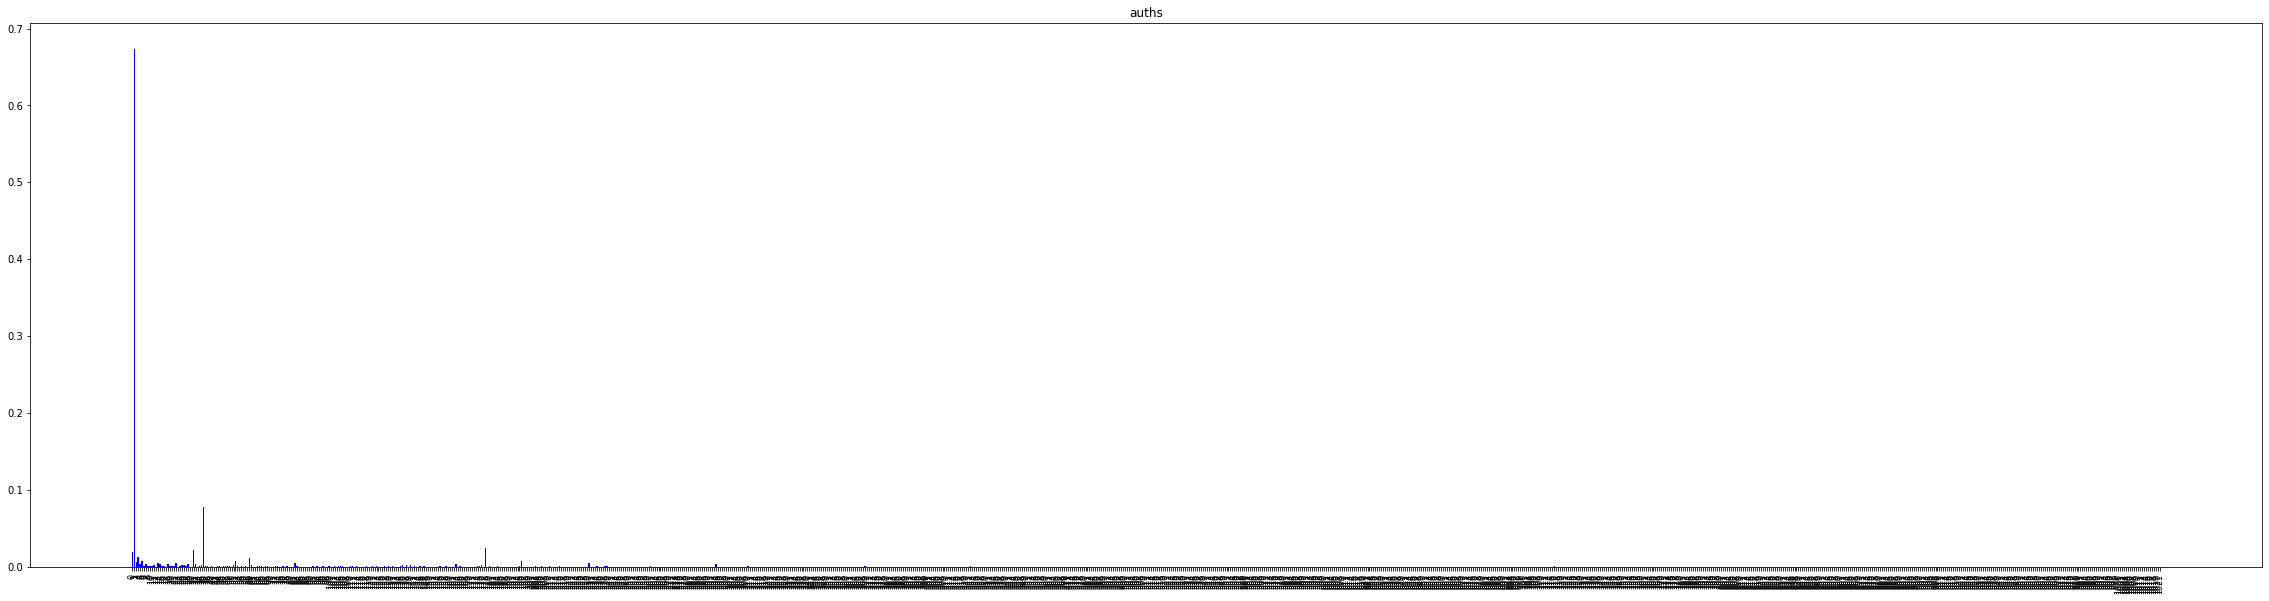

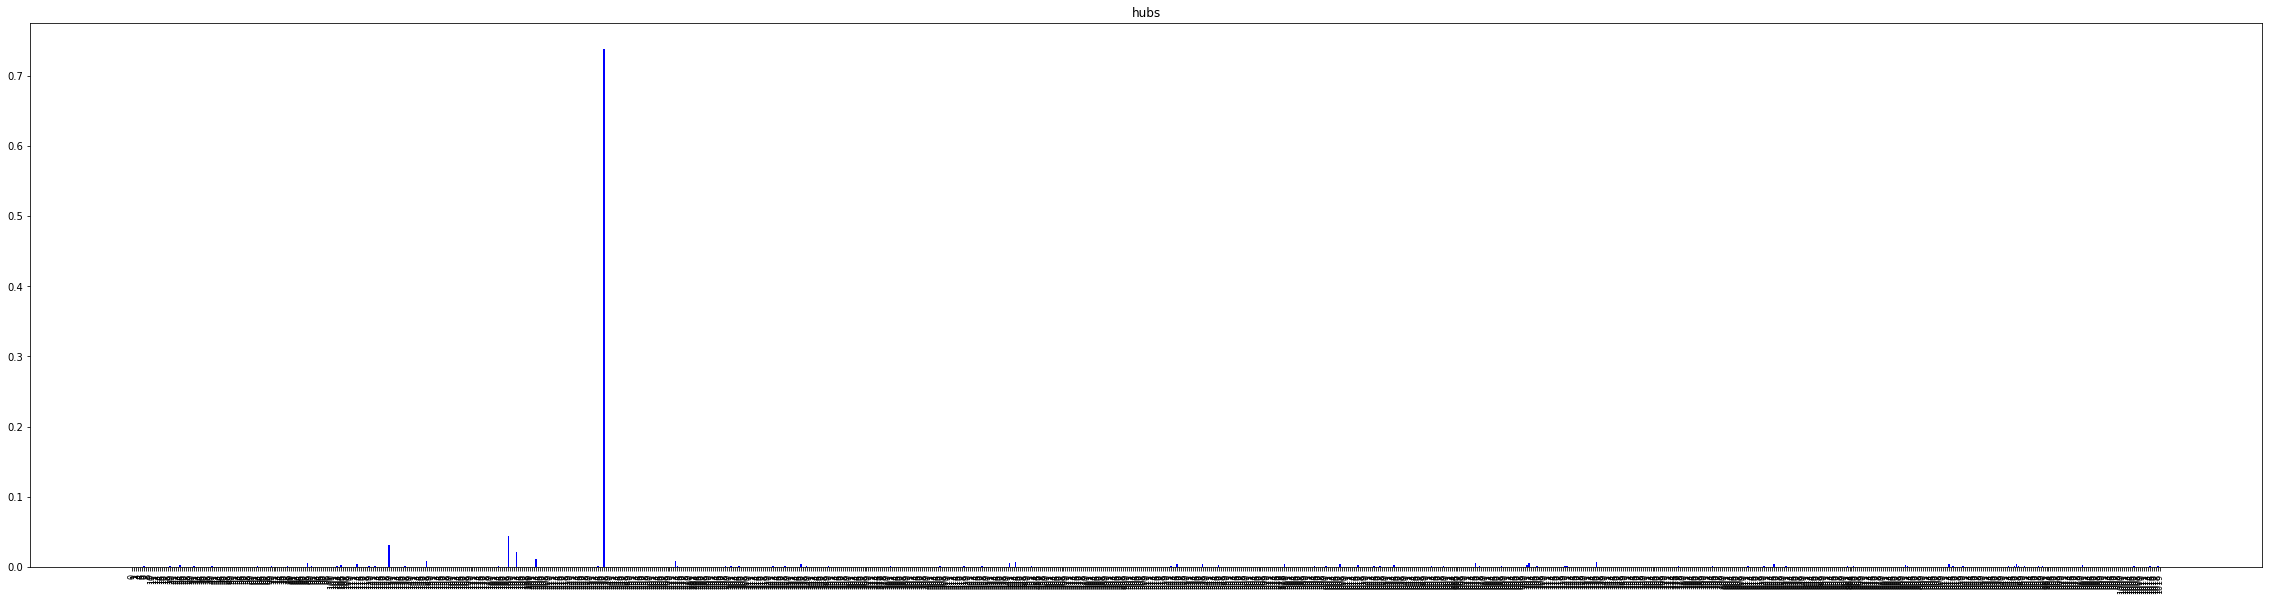

In [11]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(len(auths))))
plt.bar(labels, auths, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('auths')
plt.show()
fig = plt.figure(figsize = (40, 10))
labels = list(map(lambda x: str(x), range(len(hubs))))
plt.bar(labels, hubs, color ='blue', width = 0.7)
plt.xticks(rotation='vertical',fontsize=8)
plt.title('hubs')
plt.show()

<h5 dir="rtl">
 در نهایت نیز بیشترین امتیازها را چاپ می‌کنیم.  
</h5> 


In [32]:
k = 10
top_hubs = sorted([(i,x) for i,x in enumerate(hubs)], key = lambda x: -x[1])[:k]
top_auths = sorted([(i,x) for i,x in enumerate(auths)], key = lambda x: -x[1])[:k]
print(top_hubs)
print(top_auths)

[(40, 0.9964850053867111), (845, 0.058093302293745375), (231, 0.04091254454276203), (910, 0.02763743344131759), (12, 0.014886513994762351), (135, 0.011163666151927088), (80, 0.011138287631333501), (598, 0.009323695061557696), (739, 0.009022243057086793), (340, 0.007636657512307252)]
[(1, 0.9911062693983415), (36, 0.1140858058721279), (178, 0.03645516647852918), (31, 0.031537127253750644), (0, 0.02800287457139237), (3, 0.01821051531519488), (59, 0.016221622638043116), (52, 0.010669775250003927), (196, 0.010450749974414255), (5, 0.010196419933779984)]
